<a href="https://colab.research.google.com/github/Tony-Y/colab-notebooks/blob/master/PyTorch_Warmup_Approach1_chaining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch_warmup

     |████████████████████████████████| 314 kB 6.9 MB/s 
  Created wheel for pytorch-warmup: filename=pytorch_warmup-0.1.0-py3-none-any.whl size=5802 sha256=3f5078389d13dabebd885b35840ec85c51729180a88de68ece688c740a17ab23
  Stored in directory: /root/.cache/pip/wheels/c7/5d/24/9475e442daa1e9332c122c79fb5131b9e4e91946009365902e
Successfully built pytorch-warmup


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import pytorch_warmup as warmup
import os
from progressbar import progressbar

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 47)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
def train(model, device, train_loader, optimizer, lr_scheduler,
          warmup_scheduler, epoch, history):
    model.train()
    for batch_idx, (data, target) in enumerate(progressbar(train_loader)):
        lr = optimizer.param_groups[0]['lr']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        with warmup_scheduler.dampening():
            lr_scheduler[0].step()
            lr_scheduler[1].step()
        if (batch_idx+1) % log_interval == 0:
            loss = loss.item()
            step = warmup_scheduler.last_step
            history.write(f'{epoch},{step},{loss},{lr}\n')

In [5]:
def test(model, device, test_loader, epoch, evaluation):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in progressbar(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))
    evaluation.write(f'{epoch},{test_loss},{test_acc}\n')
    evaluation.flush()

In [6]:
torch.manual_seed(12345)
device = torch.device("cuda")

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
        datasets.EMNIST('.data', 'balanced', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1751,), (0.3332,))
                        ])),
        batch_size=64, shuffle=True, drop_last=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.EMNIST('.data', 'balanced', train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1751,), (0.3332,))
                        ])),
        batch_size=1000, shuffle=False, **kwargs)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting .data/EMNIST/raw/gzip.zip to .data/EMNIST/raw


In [7]:
warmup_type = "radam"  # choices=['linear', 'exponential', 'radam', 'none']
beta2 = 0.999
wd = 0.01
lr = 0.01
lr_min = 3e-5
epochs = 10
log_interval = 10


In [8]:
output_dir = warmup_type
os.makedirs(output_dir, exist_ok=True)

history = open(os.path.join(output_dir, 'history.csv'), 'w')
history.write('epoch,step,loss,lr\n')

evaluation = open(os.path.join(output_dir, 'evaluation.csv'), 'w')
evaluation.write('epoch,loss,accuracy\n')

model = Net().to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr,
                            betas=(0.9, beta2),
                            weight_decay=wd)
num_steps = len(train_loader) * epochs
lr_scheduler1 = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_steps, eta_min=lr_min)
lr_scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)
if warmup_type == 'linear':
        warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)
elif warmup_type == 'exponential':
        warmup_scheduler = warmup.UntunedExponentialWarmup(optimizer)
elif warmup_type == 'radam':
        warmup_scheduler = warmup.RAdamWarmup(optimizer)
elif warmup_type == 'none':
        warmup_scheduler = warmup.LinearWarmup(optimizer, 1)

for epoch in range(1, epochs + 1):
        print(f"Epoch: {epoch} of {epochs}")
        train(model, device, train_loader, optimizer, [lr_scheduler1, lr_scheduler2],
              warmup_scheduler, epoch, history)
        test(model, device, test_loader, epoch, evaluation)

history.close()
evaluation.close()

Epoch: 1 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.5352, Accuracy: 15472/18800 (82.30%)

Epoch: 2 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.5477, Accuracy: 15276/18800 (81.26%)

Epoch: 3 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4103, Accuracy: 16158/18800 (85.95%)

Epoch: 4 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.3948, Accuracy: 16293/18800 (86.66%)

Epoch: 5 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:23 Time:  0:00:23
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.3848, Accuracy: 16370/18800 (87.07%)

Epoch: 6 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:23 Time:  0:00:23
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.3779, Accuracy: 16550/18800 (88.03%)

Epoch: 7 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4167, Accuracy: 16499/18800 (87.76%)

Epoch: 8 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4452, Accuracy: 16464/18800 (87.57%)

Epoch: 9 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4731, Accuracy: 16490/18800 (87.71%)

Epoch: 10 of 10


100% (1762 of 1762) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (19 of 19) |########################| Elapsed Time: 0:00:02 Time:  0:00:02



Test set: Average loss: 0.4810, Accuracy: 16476/18800 (87.64%)



In [9]:
import pandas as pd

df_hist = pd.read_csv(os.path.join(warmup_type, "history.csv"))
df_eval = pd.read_csv(os.path.join(warmup_type, "evaluation.csv"))

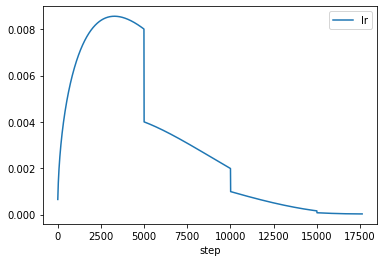

In [10]:
df_hist.plot(x="step", y="lr")

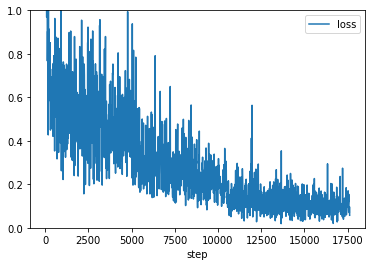

In [11]:
df_hist.plot(x="step", y="loss", ylim=(0,1))

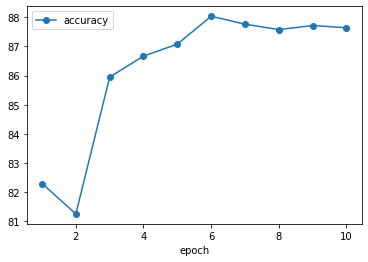

In [12]:
df_eval.plot(x="epoch", y="accuracy", marker="o")